# Transfer Learning in Emotion Recognition of the Singing vs Speaking Voice

In [31]:
import random
import librosa
import os
import shutil
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import Model
from tensorflow.python.keras.engine import training
from sklearn.utils import validation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from statannot import add_stat_annotation
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

## Create dataset folders

In [ ]:
#Code to remove surprise and disgust from the speech dataset

folder_path = "./Dataset/Speech_without_surprise_and_disgust"
file_path_list = os.listdir(folder_path)
os.mkdir(os.path.join(folder_path,"dataset"))

EMOTION_DICT_RAVDESS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}
label_dict=EMOTION_DICT_RAVDESS
label_to_int = dict({(key, i) for i, key in enumerate(label_dict.keys())})

for file in file_path_list:
    label = label_to_int[file.split("-")[2]]
    if label != 6 and label != 7:
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"dataset", file))

In [ ]:
#Code to remove the data from actor 18 and the emotions surprise and disgust from the mix dataset

folder_path = "./Dataset/Mix"
file_path_list = os.listdir(folder_path)
os.mkdir(os.path.join(folder_path,"dataset"))

for file in file_path_list:
    actor = file.split("-")[6]
    label = label_to_int[file.split("-")[2]]
    if actor != "18.wav" and label != 6 and label != 7:
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"dataset", file))

In [112]:
#Code to split the datasets into train and test data. 
#This is done randomly and without replacement. 
#The split is approximately 90% train_data and 10% test_data.

folder_path = "./Dataset/Song"
file_path_list = os.listdir(folder_path)
os.mkdir(os.path.join(folder_path,"training"))
os.mkdir(os.path.join(folder_path,"test_data"))


for file in file_path_list:
    choice = random.choices([0,1], weights=[0.90,0.10])
    if choice ==  [0]:
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"training", file))
    else:
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"test_data", file))

In [113]:
#Code to split the datasets into train and validation data for each fold. 
#This is done randomly and without replacement and intended for cross validation with holdout. 
#The split is approximately 75% train_data and 25% val_data in every fold.

folder_path = "./Dataset/Song/training"
file_path_list = os.listdir(folder_path)
for i in range(4):
    os.mkdir(os.path.join(folder_path,f"fold {i}"))
    os.mkdir(os.path.join(folder_path,f"fold {i}/train_data"))
    os.mkdir(os.path.join(folder_path,f"fold {i}/val_data"))


for file in file_path_list:
    choice = random.choices([0,1,2,3], weights=[0.25, 0.25, 0.25 ,0.25])
    if choice ==  [0]:
        for i in [1,2,3]:
            shutil.copy(os.path.join(folder_path,file), os.path.join(folder_path,f"fold {i}/train_data", file))
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"fold 0/val_data", file))
    elif choice == [1]:
        for i in [0,2,3]:
            shutil.copy(os.path.join(folder_path,file), os.path.join(folder_path,f"fold {i}/train_data", file))
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"fold 1/val_data", file))
    elif choice == [2]:
        for i in [0,1,3]:
            shutil.copy(os.path.join(folder_path,file), os.path.join(folder_path,f"fold {i}/train_data", file))
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"fold 2/val_data", file))
    else:
        for i in [0,1,2]:
            shutil.copy(os.path.join(folder_path,file), os.path.join(folder_path,f"fold {i}/train_data", file))
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"fold 3/val_data", file))

In [ ]:
#Code to split the test set of the mix dataset into song and speech. 
#This is for the first two test cases of the model trained on Mix data.

folder_path = f"./Dataset/Mix/dataset/test_data"
file_path_list = os.listdir(folder_path)
os.mkdir(os.path.join(folder_path,"Song"))
os.mkdir(os.path.join(folder_path,"Speech"))
for file in file_path_list:
    domain = file.split("-")[1]
    if domain == "01":
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"Speech", file))
    else:
        os.rename(os.path.join(folder_path,file), os.path.join(folder_path,"Song", file))

## Feature Extraction of Audio Files per Emotion

In [45]:
#Code to extract the features from the audio files in the speech dataset per emotion.

folder_path = "./Dataset/Speech_without_surprise_and_disgust (without folds)"
file_path_list = os.listdir(folder_path)

mfcc_dict = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
mel_dict = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
spectral_dict = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
chroma_dict = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
tonnetz_dict = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}


EMOTION_DICT_RAVDESS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

emotion_list = ["neutral", "calm", "happy", "sad", "angry", "fearful"]

label_dict=EMOTION_DICT_RAVDESS
label_to_int = dict({(key, i) for i, key in enumerate(label_dict.keys())})

for file in file_path_list:
    intensity = file.split("-")[3]
    if intensity=="01":  #low intensity only
        label = label_to_int[file.split("-")[2]]
        file_path = os.path.join(folder_path,file)
        audio, sr = librosa.load(file_path)

        mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)        
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)          
        chromagram = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)      
        spectral = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0) 
        tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sr).T, axis=0)

        emotion = emotion_list[label]
        mfcc_dict[emotion].append(mfcc)
        mel_dict[emotion].append(mel)
        spectral_dict[emotion].append(spectral)
        chroma_dict[emotion].append(chromagram)
        tonnetz_dict[emotion].append(tonnetz)

/home/lucia/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=1012
  return f(*args, **kwargs)


In [46]:
#Code to extract the features from the audio files in the song dataset per emotion.

folder_path = "./Dataset/Song (without folds)"
file_path_list = os.listdir(folder_path)

mfcc_dict2 = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
mel_dict2 = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
spectral_dict2 = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
chroma_dict2 = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}
tonnetz_dict2 = {"neutral":[], "calm":[], "happy":[], "sad":[], "angry":[], "fearful":[]}


EMOTION_DICT_RAVDESS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

emotion_list = ["neutral", "calm", "happy", "sad", "angry", "fearful"]

label_dict=EMOTION_DICT_RAVDESS
label_to_int = dict({(key, i) for i, key in enumerate(label_dict.keys())})

for file in file_path_list:
    intensity = file.split("-")[3]
    if intensity=="01":  #low intensity only
        label = label_to_int[file.split("-")[2]]
        file_path = os.path.join(folder_path,file)
        audio, sr = librosa.load(file_path)

        mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)        
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)          
        chromagram = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)      
        spectral = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0) 
        tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sr).T, axis=0)

        emotion = emotion_list[label]
        mfcc_dict2[emotion].append(mfcc)
        mel_dict2[emotion].append(mel)
        spectral_dict2[emotion].append(spectral)
        chroma_dict2[emotion].append(chromagram)
        tonnetz_dict2[emotion].append(tonnetz)

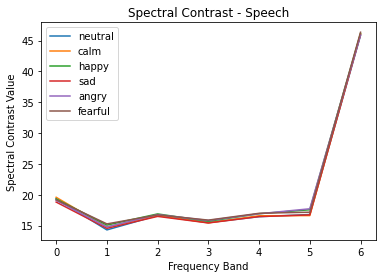

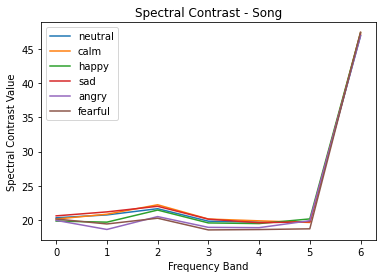

In [46]:
plt.plot(range(7), np.mean(spectral_dict["neutral"], axis=0), label="neutral")
plt.plot(range(7), np.mean(spectral_dict["calm"], axis=0), label="calm")
plt.plot(range(7), np.mean(spectral_dict["happy"], axis=0), label="happy")
plt.plot(range(7), np.mean(spectral_dict["sad"], axis=0), label="sad")
plt.plot(range(7), np.mean(spectral_dict["angry"], axis=0), label="angry")
plt.plot(range(7), np.mean(spectral_dict["fearful"], axis=0), label="fearful")
plt.xlabel("Frequency Band")
plt.ylabel("Spectral Contrast Value")
plt.title("Spectral Contrast - Speech")
plt.legend()
plt.show()

plt.plot(range(7), np.mean(spectral_dict2["neutral"], axis=0), label="neutral") 
plt.plot(range(7), np.mean(spectral_dict2["calm"], axis=0), label="calm")
plt.plot(range(7), np.mean(spectral_dict2["happy"], axis=0), label="happy")
plt.plot(range(7), np.mean(spectral_dict2["sad"], axis=0), label="sad")
plt.plot(range(7), np.mean(spectral_dict2["angry"], axis=0), label="angry")
plt.plot(range(7), np.mean(spectral_dict2["fearful"], axis=0), label="fearful")
plt.xlabel("Frequency Band")
plt.ylabel("Spectral Contrast Value")
plt.title("Spectral Contrast - Song")
plt.legend()
plt.show()

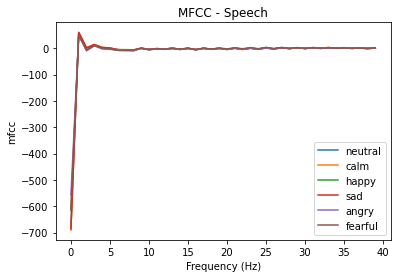

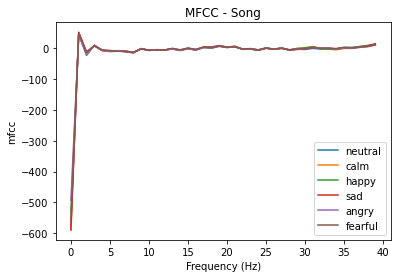

In [45]:
plt.plot(range(40), np.mean(mfcc_dict["neutral"], axis=0), label="neutral")
plt.plot(range(40), np.mean(mfcc_dict["calm"], axis=0), label="calm")
plt.plot(range(40), np.mean(mfcc_dict["happy"], axis=0), label="happy")
plt.plot(range(40), np.mean(mfcc_dict["sad"], axis=0), label="sad")
plt.plot(range(40), np.mean(mfcc_dict["angry"], axis=0), label="angry")
plt.plot(range(40), np.mean(mfcc_dict["fearful"], axis=0), label="fearful")
plt.xlabel("Frequency (Hz)")
plt.ylabel("mfcc")
plt.title("MFCC - Speech")
plt.legend()
plt.show()

plt.plot(range(40), np.mean(mfcc_dict2["neutral"], axis=0), label="neutral")
plt.plot(range(40), np.mean(mfcc_dict2["calm"], axis=0), label="calm")
plt.plot(range(40), np.mean(mfcc_dict2["happy"], axis=0), label="happy")
plt.plot(range(40), np.mean(mfcc_dict2["sad"], axis=0), label="sad")
plt.plot(range(40), np.mean(mfcc_dict2["angry"], axis=0), label="angry")
plt.plot(range(40), np.mean(mfcc_dict2["fearful"], axis=0), label="fearful")
plt.xlabel("Frequency (Hz)")
plt.ylabel("mfcc")
plt.title("MFCC - Song")
plt.legend()
plt.show()

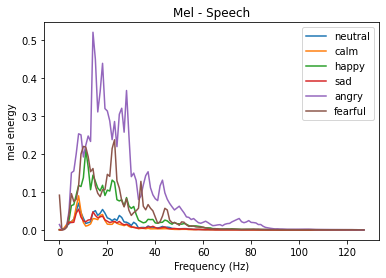

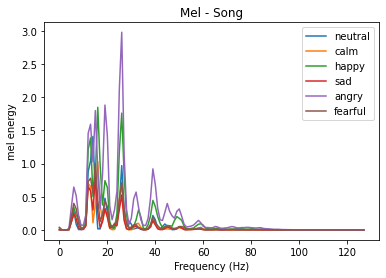

In [47]:
plt.plot(range(128), np.mean(mel_dict["neutral"], axis=0), label="neutral")
plt.plot(range(128), np.mean(mel_dict["calm"], axis=0), label="calm")
plt.plot(range(128), np.mean(mel_dict["happy"], axis=0), label="happy")
plt.plot(range(128), np.mean(mel_dict["sad"], axis=0), label="sad")
plt.plot(range(128), np.mean(mel_dict["angry"], axis=0), label="angry")
plt.plot(range(128), np.mean(mel_dict["fearful"], axis=0), label="fearful")
plt.xlabel("Frequency (Hz)")
plt.ylabel("mel energy")
plt.title("Mel - Speech")
plt.legend()
plt.show()

plt.plot(range(128), np.mean(mel_dict2["neutral"], axis=0), label="neutral")
plt.plot(range(128), np.mean(mel_dict2["calm"], axis=0), label="calm")
plt.plot(range(128), np.mean(mel_dict2["happy"], axis=0), label="happy")
plt.plot(range(128), np.mean(mel_dict2["sad"], axis=0), label="sad")
plt.plot(range(128), np.mean(mel_dict2["angry"], axis=0), label="angry")
plt.plot(range(128), np.mean(mel_dict2["fearful"], axis=0), label="fearful")
plt.xlabel("Frequency (Hz)")
plt.ylabel("mel energy")
plt.title("Mel - Song")
plt.legend()
plt.show()

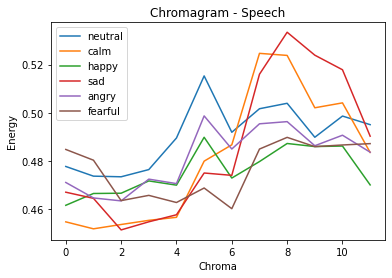

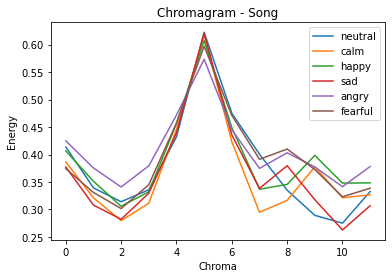

In [48]:
plt.plot(range(12), np.mean(chroma_dict["neutral"], axis=0), label="neutral")
plt.plot(range(12), np.mean(chroma_dict["calm"], axis=0), label="calm")
plt.plot(range(12), np.mean(chroma_dict["happy"], axis=0), label="happy")
plt.plot(range(12), np.mean(chroma_dict["sad"], axis=0), label="sad")
plt.plot(range(12), np.mean(chroma_dict["angry"], axis=0), label="angry")
plt.plot(range(12), np.mean(chroma_dict["fearful"], axis=0), label="fearful")
plt.xlabel("Chroma")
plt.ylabel("Energy")
plt.title("Chromagram - Speech")
plt.legend()
plt.show()

plt.plot(range(12), np.mean(chroma_dict2["neutral"], axis=0), label="neutral")
plt.plot(range(12), np.mean(chroma_dict2["calm"], axis=0), label="calm")
plt.plot(range(12), np.mean(chroma_dict2["happy"], axis=0), label="happy")
plt.plot(range(12), np.mean(chroma_dict2["sad"], axis=0), label="sad")
plt.plot(range(12), np.mean(chroma_dict2["angry"], axis=0), label="angry")
plt.plot(range(12), np.mean(chroma_dict2["fearful"], axis=0), label="fearful")
plt.xlabel("Chroma")
plt.ylabel("Energy")
plt.title("Chromagram - Song")
plt.legend()
plt.show()

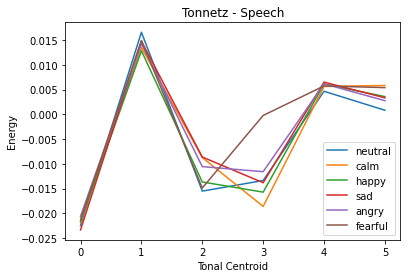

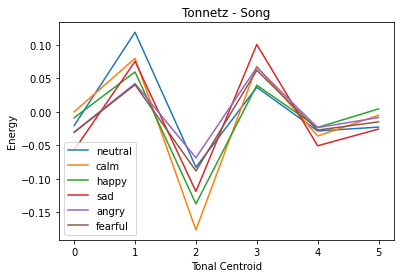

In [47]:
plt.plot(range(6), np.mean(tonnetz_dict["neutral"], axis=0), label="neutral")
plt.plot(range(6), np.mean(tonnetz_dict["calm"], axis=0), label="calm")
plt.plot(range(6), np.mean(tonnetz_dict["happy"], axis=0), label="happy")
plt.plot(range(6), np.mean(tonnetz_dict["sad"], axis=0), label="sad")
plt.plot(range(6), np.mean(tonnetz_dict["angry"], axis=0), label="angry")
plt.plot(range(6), np.mean(tonnetz_dict["fearful"], axis=0), label="fearful")
plt.ylabel("Energy")
plt.xlabel("Tonal Centroid")
plt.title("Tonnetz - Speech")
plt.legend()
plt.show()

plt.plot(range(6), np.mean(tonnetz_dict2["neutral"], axis=0), label="neutral")
plt.plot(range(6), np.mean(tonnetz_dict2["calm"], axis=0), label="calm")
plt.plot(range(6), np.mean(tonnetz_dict2["happy"], axis=0), label="happy")
plt.plot(range(6), np.mean(tonnetz_dict2["sad"], axis=0), label="sad")
plt.plot(range(6), np.mean(tonnetz_dict2["angry"], axis=0), label="angry")
plt.plot(range(6), np.mean(tonnetz_dict2["fearful"], axis=0), label="fearful")
plt.ylabel("Energy")
plt.xlabel("Tonal Centroid")
plt.title("Tonnetz - Song")
plt.legend()
plt.show()

## Model

In [115]:
class SpeechModel:
    def __init__(self, num_output_classes) -> None:
        self.num_output_classes = num_output_classes

    def getRAVDESS(self) -> Model:
        """
        Returns a tensorflow model that is according to 
        specifications of the baseline CNN model 
        in the paper of Issa, Demirci and Yazici.
        """
        input_layer = L.Input(shape=(193, 1))

        cnn1 = L.Conv1D(256, (5))(input_layer)
        batch_norm1 = L.BatchNormalization()(cnn1)
        relu1 = L.ReLU()(batch_norm1)

        cnn2 = L.Conv1D(128, (5))(relu1)
        relu2 = L.ReLU()(cnn2)
        dropout1 = L.Dropout(0.1)(relu2)
        batch_norm2 = L.BatchNormalization()(dropout1)

        max_pool1 = L.MaxPool1D(8)(batch_norm2)

        conv3 = L.Conv1D(128, (5))(max_pool1)
        
        relu3 = L.ReLU()(conv3)
        conv4 = L.Conv1D(128, (5))(relu3)
        relu4 = L.ReLU()(conv4)
        conv5 = L.Conv1D(128, (5))(relu4)
        batch_norm4 = L.BatchNormalization()(conv5)
        relu5 = L.ReLU()(batch_norm4)
        dropout2 = L.Dropout(0.2)(relu5)

        conv6 = L.Conv1D(128, (5))(dropout2)
        flatten = L.Flatten()(conv6)
        dropout3 = L.Dropout(0.2)(flatten)

        output_logits = L.Dense(self.num_output_classes)(dropout3)
        batch_norm5 = L.BatchNormalization()(output_logits)
        softmax = L.Softmax()(batch_norm5)
        model = Model(inputs=[input_layer], outputs=[softmax])
        optimizer = tf.keras.optimizers.RMSprop(1e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        metrics = tf.keras.metrics.SparseCategoricalAccuracy()  #metrics added, for plotting the accuracy
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics]) 

        return model

In [121]:
EMOTION_DICT_RAVDESS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}


def process_audio_clip(file_path, label):
    """
    Extracts the audio features from the audio fragments.
    Arguments:
    file_path : String
    label : Int
    """
    file_path = file_path.numpy()
    audio, sr = librosa.load(file_path)
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)        
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)          
    chromagram = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)      
    spectral = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0) 
    tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sr).T, axis=0)          
    extracted_features = tf.concat([mfcc, mel, chromagram, spectral, tonnetz], axis=0)
    return extracted_features, label

def create_model(num_output_classes):
    """
    Creates the computational model.
    Arguments:
    num_output_classes: Int
    """
    speechModel = SpeechModel(num_output_classes)
    model = speechModel.getRAVDESS()
    return model

In [119]:
def get_dataset(
    data_dir,
    label_dict,
    batch_size=128,
    cache=False,
):
    """
    Creates a `tf.data.Dataset` object.
    Arguments:
    data_dir : String
    label_dict : dictionary with labels
    batch_size : Int
    cache : Boolean
    """

    def decompose_label(file_path: str):
        return label_to_int[file_path.split("-")[2]]

    def tf_wrapper_process_audio_clip(file_path, label):
        extracted_features, label = tf.py_function(
            process_audio_clip, [file_path, label], [tf.float32, tf.int32]
        )
        extracted_features = tf.expand_dims(extracted_features, -1)
        return extracted_features, label
    
    file_path_list = os.listdir(data_dir)
    label_to_int = dict({(key, i) for i, key in enumerate(label_dict.keys())})
    labels = [decompose_label(file_path) for file_path in file_path_list]
    file_path_list = [
                os.path.join(data_dir, path) for path in file_path_list
            ]
    dataset = tf.data.Dataset.from_tensor_slices((file_path_list, labels))
    dataset = dataset.map(tf_wrapper_process_audio_clip, num_parallel_calls=tf.data.AUTOTUNE)
    if cache:
        dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

## Training

In [ ]:
# To avoid librosa's warning about n_fft being too large. 
warnings.filterwarnings("ignore", category=UserWarning)

EPOCHS = 200
CACHE = False
BATCH_SIZE = 32 
no_disgust_or_surprise = True
NUM_LABELS = 8
n_folds = 4
label_dict = EMOTION_DICT_RAVDESS

acc_per_fold = []
loss_per_fold = []
all_predictions = []
all_labels = []

if no_disgust_or_surprise:
    NUM_LABELS = 6            #Sets the amount of units of the dense layer to 6, instead of 8
    label_dict.pop("07")      #Deletes the emotion disgust from the dictionary of emotions
    label_dict.pop("08")      #Deletes the emotion surprise form the dictionary of emotions
    
for fold in range(n_folds):
    print('------------------------------------------------------------------------')
    print("Fold #{}".format(fold))
    
    train_dir = f"./Dataset/Speech_without_surprise_and_disgust/dataset/training/fold {fold}/train_data"
    #train_dir = f"./Dataset/Song/training/fold {fold}/train_data"
    val_dir = f"./Dataset/Speech_without_surprise_and_disgust/dataset/training/fold {fold}/val_data"
    #val_dir = "./Dataset/Song/training/fold {fold}/val_data"
    
    train_ds = get_dataset(
        data_dir=train_dir,
        label_dict=label_dict,
        batch_size=BATCH_SIZE,
        cache=CACHE,
    )
    
    val_ds = get_dataset(
        data_dir=val_dir,
        label_dict=label_dict,
        batch_size=BATCH_SIZE,
        cache=CACHE,
    )
     
    #Training:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
    )
    
    model.save(f"saved_model/{EPOCHS}_trained_model-speech_for_transfer-fold: {fold}")
    
    #Plot of the train and validation loss:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'model loss of fold {fold}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

## Testing

### Transfer Learning

In [ ]:
#For the two transfer learning cases, the model was tested on the entire dataset for every fold 

acc_per_fold = []
loss_per_fold = []
all_predictions = []
all_labels = []
label_dict = EMOTION_DICT_RAVDESS
no_disgust_or_surprise = True
n_folds = 4

if no_disgust_or_surprise:
    NUM_LABELS = 6
    label_dict.pop("07")
    label_dict.pop("08")

test_dir = f"./Dataset/Song (without folds)"
#test_dir = f"./Dataset/Speech_without_surprise_and_disgust (without folds)"

test_ds = get_dataset(
        data_dir=test_dir,
        training=False,
        label_dict=label_dict,
        batch_size=BATCH_SIZE,
        cache=CACHE,
    )

for fold in range(n_folds):
    print('------------------------------------------------------------------------')
    print("Fold #{}".format(fold))
    
    file_path_list = os.listdir(test_dir)
    save_model_path = f"saved_model/200_trained_model-song-fold#{fold}"
    
    model = tf.keras.models.load_model(save_model_path)
    
    #Evaluation
    scores = model.evaluate(test_ds)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    #Prediction:
    predictions = model.predict(x=test_ds)
    predictions = np.argmax(predictions, axis=-1)
    all_predictions.extend(predictions)
    labels = []
    for image_batch, label_batch in test_ds: 
        labels.append(label_batch)
    labels = tf.concat([item for item in labels], axis = 0)
    all_labels.extend(labels)
    cm = confusion_matrix(labels, predictions, normalize='true', labels=range(6))
    plt.rcParams["figure.figsize"] = (10,10)
    ax = sns.heatmap(cm, annot=True, 
                fmt='.2%')

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label');
    ax.xaxis.set_ticklabels([*label_dict.values()])
    ax.yaxis.set_ticklabels([*label_dict.values()])
    plt.show()

cm = confusion_matrix(all_labels, all_predictions, normalize='true')
plt.rcParams["figure.figsize"] = (10,10)
ax = sns.heatmap(cm, annot=True, 
            fmt='.2%')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label');
ax.xaxis.set_ticklabels([*label_dict.values()])
ax.yaxis.set_ticklabels([*label_dict.values()])
plt.show()

In [ ]:
#Summary of accuracies and losses:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

### No Transfer Learning

In [ ]:
#For all the test cases without transfer learning, the model was tested on
#the same 1-10th of the complete dataset, so on the test set

acc_per_fold = []
loss_per_fold = []
all_predictions = []
all_labels = []
label_dict = EMOTION_DICT_RAVDESS
no_disgust_or_surprise = True
n_folds = 4

if no_disgust_or_surprise:
    label_dict.pop("07")      #Deletes the emotion disgust from the dictionary of emotions
    label_dict.pop("08")      #Deletes the emotion surprise form the dictionary of emotions

for fold in range(n_folds):
    print('------------------------------------------------------------------------')
    print("Fold #{}".format(fold))
    
    test_dir = f"./Dataset/Song/test_data"
    #test_dir = f"./Dataset/Speech_without_surprise_and_disgust/dataset/test_data"
    file_path_list = os.listdir(test_dir)
    save_model_path = f"saved_model/200_trained_model-speech-fold#{fold}"
    
    test_ds = get_dataset(
        data_dir=test_dir,
        training=False,
        label_dict=label_dict,
        batch_size=BATCH_SIZE,
        cache=CACHE,
    )
    
    model = tf.keras.models.load_model(save_model_path)
    
    #Evaluation:
    scores = model.evaluate(test_ds)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    #An example output is Score for fold 0: loss of 1.8694514036178589; sparse_categorical_accuracy of 23.553718626499176%
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    #Prediction:
    predictions = model.predict(x=test_ds)
    predictions = np.argmax(predictions, axis=-1)
    all_predictions.extend(predictions)
    
    labels = []
    for image_batch, label_batch in test_ds: 
        labels.append(label_batch)
    labels = tf.concat([item for item in labels], axis = 0)
    all_labels.extend(labels)
    
    cm = confusion_matrix(labels, predictions, normalize='true')
    plt.rcParams["figure.figsize"] = (10,10)
    ax = sns.heatmap(cm, annot=True, 
                fmt='.2%')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label');
    ax.xaxis.set_ticklabels([*label_dict.values()])
    ax.yaxis.set_ticklabels([*label_dict.values()])
    plt.show()
    
cm = confusion_matrix(all_labels, all_predictions, normalize='true')
plt.rcParams["figure.figsize"] = (10,10)
ax = sns.heatmap(cm, annot=True, 
            fmt='.2%')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label');
ax.xaxis.set_ticklabels([*label_dict.values()])
ax.yaxis.set_ticklabels([*label_dict.values()])
plt.show()
#For an example confusion matrix, see the paper

In [ ]:
#Summary of accuracies and losses:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

## T-test

In [2]:
pop_mean = (1/6)*100 #chance level accuracy. It is 1/6 as there are 6 emotions

acc_list_song_speech = np.array([22.537878155708313, 24.905303120613098, 25.662878155708313, 25.757575035095215])
song_speech_pval = stats.ttest_1samp(a=acc_list_song_speech, popmean=pop_mean).pvalue
#pval = 0.0017340706612829122 --> statistically significant

acc_list_song = np.array([85.12396812438965, 84.3137264251709, 85.60606241226196, 81.27490282058716])
song_pval = stats.ttest_1samp(a=acc_list_song,popmean=pop_mean).pvalue
#pval = 6.6095749727651635e-06 --> statistically significant

acc_list_speech_song = np.array([26.112759113311768, 29.277941584587097, 31.948566436767578, 28.486648201942444])
speech_song_pval = stats.ttest_1samp(a=acc_list_speech_song, popmean=pop_mean).pvalue
#pval = 0.001998651171817521 --> statistically significant

acc_list_speech = np.array([47.22222089767456, 57.553958892822266, 52.28216052055359, 49.824562668800354])
speech_pval = stats.ttest_1samp(a=acc_list_speech, popmean=pop_mean).pvalue
#pval = 0.0005388167014885615 --> statistically significant

pop_mean_full = (1/8)*100  #Chance level accuracy for when there are 8 possible emotions
acc_list_speech_full = np.array([46.594005823135376, 41.741740703582764, 45.67567706108093, 50.54054260253906])
speech_full_pval = stats.ttest_1samp(a=acc_list_speech_full, popmean=pop_mean_full).pvalue
#pval = 0.00033767997467292106 --> statistically significant

acc_list_mix_speech = np.array([56.3265323638916, 54.581671953201294, 57.14285969734192, 62.12121248245239])
mix_speech_pval = stats.ttest_1samp(a=acc_list_mix_speech, popmean=pop_mean).pvalue
#pval = 0.00013570614586500473 --> statistically significant

acc_list_mix_song = np.array([80.35714030265808, 84.21052694320679, 84.7736597061157, 84.67432856559753])
mix_song_pval = stats.ttest_1samp(a=acc_list_mix_song, popmean=pop_mean).pvalue
#pval = 8.691864920993966e-06 --> statistically significant

acc_list_mix = np.array([69.1428542137146, 68.68476271629333, 70.70707082748413, 73.33333492279053])
mix_pval = stats.ttest_1samp(a=acc_list_mix, popmean=pop_mean).pvalue
#pval = 1.6321899718753925e-05 --> statistically significant

accs = [acc_list_song_speech, acc_list_song, acc_list_speech_song, acc_list_speech, acc_list_speech_full,
        acc_list_mix_speech, acc_list_mix_song, acc_list_mix]

In [102]:
paired_pval=stats.ttest_rel(a=acc_list_mix_speech,b=acc_list_speech).pvalue
#pval=0.17619661742244597 --> not statistically significant

paired_pval2=stats.ttest_rel(a=acc_list_mix_song,b=acc_list_song).pvalue
#pval=0.7536896917495137 --> not statistically significant

paired_pval3=stats.ttest_rel(a=acc_list_song,b=acc_list_speech_song).pvalue
#pval=3.423452524391539e-05 --> statistically significant

paired_pval4=stats.ttest_rel(a=acc_list_speech,b=acc_list_song_speech).pvalue
#pval=0.0008252618094565344 --> statistically significant

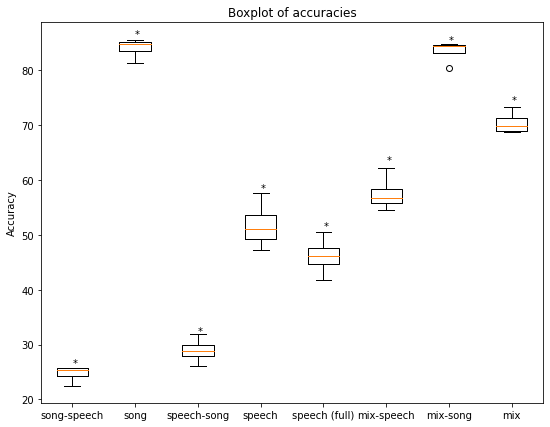

In [44]:
plt.figure(figsize=(9, 7))
bplot = plt.boxplot(accs)
plt.title("Boxplot of accuracies")
order = ["song-speech", "song", "speech-song", "speech", "speech (full)", "mix-speech", "mix-song", "mix"]
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], order)
plt.ylabel("Accuracy")
plt.text(y=26, x=1,s="*")
plt.text(y=86, x=2,s="*")
plt.text(y=32, x=3,s="*")
plt.text(y=58, x=4,s="*")
plt.text(y=51, x=5,s="*")
plt.text(y=63, x=6,s="*")
plt.text(y=85, x=7,s="*")
plt.text(y=74, x=8,s="*")
plt.show()